<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aggregating-algorithms" data-toc-modified-id="Aggregating-algorithms-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aggregating algorithms</a></span><ul class="toc-item"><li><span><a href="#Hedge-demo" data-toc-modified-id="Hedge-demo-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hedge demo</a></span></li></ul></li><li><span><a href="#Regression-with-different-parametrizations" data-toc-modified-id="Regression-with-different-parametrizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression with different parametrizations</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Aggregating algorithms

In [3]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBanditEnv
from bandits.pricing.agents import UCB1OAgent, SLRAgent

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

I will test the aggregating algorithms in this section

1. input (price, matrix NxM)
2. get aggregated answer (ask each expert)
3. get loss
4. update estimates (weights)

In [4]:
from copy import deepcopy
from bandits.online_models import ConstantModel, SimpleLinearRegressor, OnlinePredictionEnv
from bandits.aggregating_algorithms import SimpleMeanAggregatingAlgorithm, Hedge

In [5]:
N_SIMULATIONS = 50
T = 10000

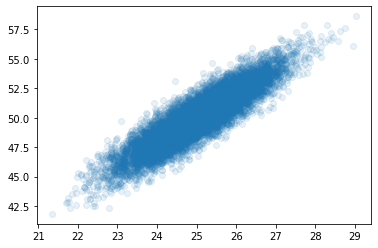

In [6]:
np.random.seed(1)
questions = np.random.normal(size=(T,), loc=25, scale=1)
answers = questions * 2 + np.random.normal(size=(T,), loc=0, scale=1)
plt.scatter(questions, answers, alpha=0.1);

In [7]:
models = [ConstantModel(10), ConstantModel(50), ConstantModel(100), SimpleLinearRegressor(0, 0)]
agg_algorithm = SimpleMeanAggregatingAlgorithm(models)

In [8]:
models[0].predict(np.array([1, 2]))

array([10., 10.])

In [9]:
agg_algorithm.get_prediction(np.array([1, 2, 3, 4, 5]))

array([40., 40., 40., 40., 40.])

In [10]:
def simulate_agg_algorithm(T, agg_algorithm_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    questions = np.random.normal(size=(T,), loc=25, scale=1)
    answers = questions * 2 + np.random.normal(size=(T,), loc=0, scale=1)
    env = OnlinePredictionEnv(questions, answers)
    
    name, alg_func = agg_algorithm_tuple
    alg = alg_func()
    losses_history = []
    for _ in range(T):
        x = env.get_context()
        x = np.array([x])
        final_prediction = alg.get_prediction(x)[0]
        y = env.get_true_value()
        y = np.array([y])
        
        loss = np.abs(final_prediction-y)
        losses_history.append(loss)
        alg.update_estimates(x, y)
    
    losses = np.cumsum(losses_history)
    return rng_seed, name, losses

In [11]:
models = [ConstantModel(10), ConstantModel(50), ConstantModel(100)]
models_with_lr = [ConstantModel(10), ConstantModel(50), ConstantModel(100), SimpleLinearRegressor(0, 0)]
only_lr = [SimpleLinearRegressor(0, 0)]
agent_funcs = [
    ("Mean constants", lambda: SimpleMeanAggregatingAlgorithm(deepcopy(models))),
    ("Mean with LR", lambda: SimpleMeanAggregatingAlgorithm(deepcopy(models_with_lr))),
    ("only LR", lambda: SimpleMeanAggregatingAlgorithm(deepcopy(only_lr))),
    ("Hedge Constants", lambda: Hedge(deepcopy(models))),
    ("Hedge with LR", lambda: Hedge(deepcopy(models_with_lr))),
]

In [12]:
Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [13]:
# # just to check if it works
# for n_simulation, agg_algorithm_tuple in tqdm(combinations):
#     rng_seed, name, losses = simulate_agg_algorithm(T, agg_algorithm_tuple, n_simulation)
#     break

In [14]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agg_algorithm)(T, agg_algorithm_tuple, n_simulation) for n_simulation, agg_algorithm_tuple in tqdm(combinations))

  0%|          | 0/250 [00:00<?, ?it/s]

In [15]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [16]:
results_df.head()

,simulation,algorithm,regret
0,0,Mean constants,"[0.2071165124991694, 4.535792854344521, 9.2777..."
1,0,Mean with LR,"[13.126216820834166, 22.13087381232215, 25.829..."
2,0,only LR,"[53.126216820834166, 102.13087381232215, 102.6..."
3,0,Hedge Constants,"[0.2071165124991623, 1.2024594543886877, 2.611..."
4,0,Hedge with LR,"[13.126216820834166, 14.121559762029293, 15.53..."


In [17]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

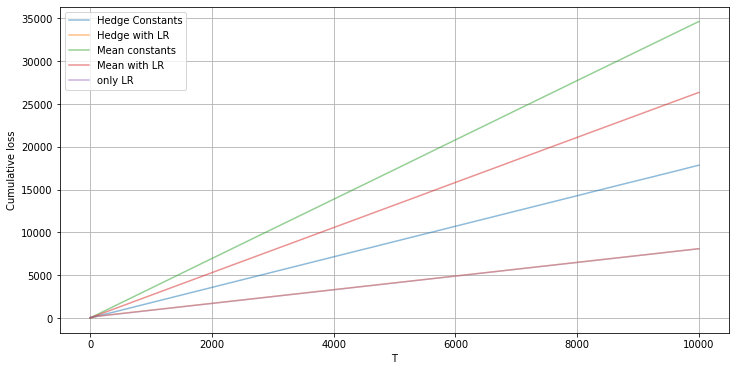

In [18]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Cumulative loss')
plt.grid();

the purple one coincides with the orange, nice!

### Hedge demo

In [19]:
def simulate_agg_algorithm(T, agg_algorithm_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    questions = np.random.normal(size=(T,), loc=25, scale=1)
    answers = questions * 2 + np.random.normal(size=(T,), loc=0, scale=1)
    env = OnlinePredictionEnv(questions, answers)
    plt.scatter(questions, answers, alpha=0.1);
    
    name, alg_func = agg_algorithm_tuple
    alg = alg_func()
    losses_history = []
    for _ in range(T):
        x = env.get_context()
        x = np.array([x])
        final_prediction = alg.get_prediction(x)[0]
        y = env.get_true_value()
        y = np.array([y])
        
        loss = np.abs(final_prediction-y)
        losses_history.append(loss)
        alg.update_estimates(x, y)
    
    losses = np.cumsum(losses_history)
    wh = alg.weights_history
    return rng_seed, name, losses, wh

In [20]:
agg_algorithm_tuple = ("Hedge Constants", lambda: Hedge(deepcopy(models)))

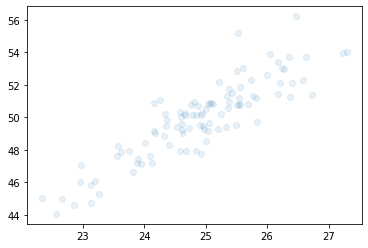

In [21]:
rng_seed, name, losses, wh = simulate_agg_algorithm(100, agg_algorithm_tuple)

In [22]:
tmp = pd.DataFrame(wh).add_prefix('agent_')
tmp['T'] = tmp.index
tmp = pd.wide_to_long(tmp, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'weight'})

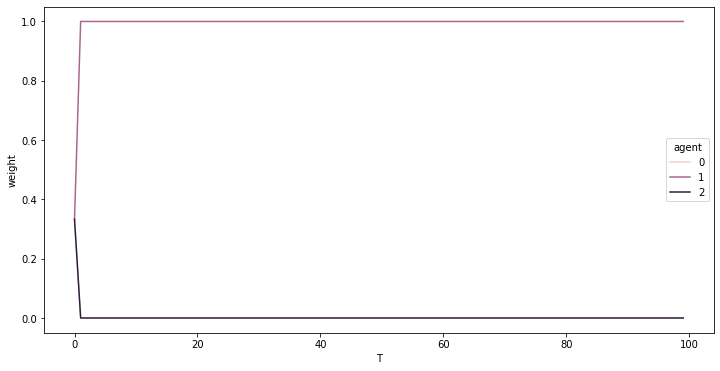

In [23]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='weight', hue='agent', data=tmp);

## Regression with different parametrizations

In [24]:
def simulate_agg_algorithm(T, agg_algorithm_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    questions = np.random.normal(size=(T,), loc=25, scale=1)
    answers = questions * 2 + np.random.normal(size=(T,), loc=0, scale=1)
    env = OnlinePredictionEnv(questions, answers)
    plt.scatter(questions, answers, alpha=0.1);
    
    name, alg_func = agg_algorithm_tuple
    alg = alg_func()
    losses_history = []
    for _ in range(T):
        x = env.get_context()
        final_prediction = alg.get_prediction(x)
        true_value = env.get_true_value()
        
        loss = np.abs(final_prediction-true_value)
        losses_history.append(loss)
        alg.update_estimates(true_value)
    
    losses = np.cumsum(losses_history)
    wh = alg.weights_history
    return rng_seed, name, losses, wh

In [25]:
T = 10000

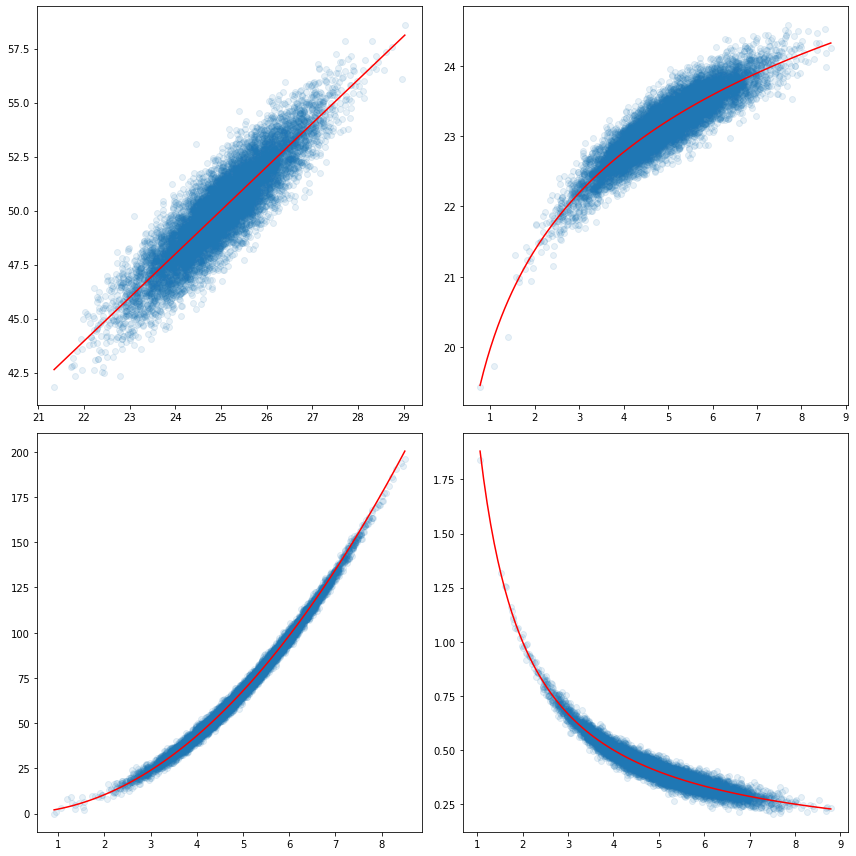

In [26]:
fig,axs=plt.subplots(figsize=(12, 12))

plt.subplot(2, 2, 1)
np.random.seed(1)
x = np.random.normal(size=(T,), loc=25, scale=1)
y = x * 2 + np.random.normal(size=(T,), loc=0, scale=1)
slr = SimpleLinearRegressor()
slr.update(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red');

plt.subplot(2, 2, 2)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = 20+np.log(x) * 2 + np.random.normal(size=(T,), loc=0, scale=0.2)
slr = SimpleLinearRegressor(x_transform=np.log)
slr.update(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red');

plt.subplot(2, 2, 3)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = np.exp(1+np.log(x) * 2) + np.random.normal(size=(T,), loc=0, scale=2)
y = y.clip(0.0001)
slr = SimpleLinearRegressor(x_transform=np.log, y_transform=np.log, y_inv_transform=np.exp)
slr.update(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red');

plt.subplot(2, 2, 4)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = 2 * 1/(x) + np.random.normal(size=(T,), loc=0, scale=0.025)
slr = SimpleLinearRegressor(x_transform=lambda x: 1/x)
slr.update(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')

fig.tight_layout();